## For documentation

https://docs.stormglass.io/#/weather

In [1]:
import requests
import json
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from datetime import datetime, timedelta

In [2]:
API_KEY = "464a49aa-60e7-11f0-976d-0242ac130006-464a4a04-60e7-11f0-976d-0242ac130006"
BASE_URL = "https://api.stormglass.io/v2/weather/point"

### Wind data @ 200hPa (10m above sea level)

In [3]:
def fetch_wind_data(lat, lng, params=("windSpeed","windDirection","gust","visibility"), start=None, end=None, cache_file="wind_cache.json"):
    if os.path.exists(cache_file):
        print(f"Loading data from cache file: {cache_file}")
        with open(cache_file, "r") as f:
            data = json.load(f)
        return data["hours"]
    
    headers = {"Authorization": API_KEY}
    payload = {
        "lat": lat,
        "lng": lng,
        "params": ",".join(params),
    }
    if start:
        payload["start"] = start
    if end:
        payload["end"] = end

    print("Fetching data from Stormglass API...")
    resp = requests.get(BASE_URL, params=payload, headers=headers)
    resp.raise_for_status()
    data = resp.json()
    
    with open(cache_file, "w") as f:
        json.dump(data, f)
    print(f"Data saved to {cache_file}")

    return data["hours"]

def parse_wind_timeseries(wind_data):
    times_str = [sample["time"] for sample in wind_data]
    wind_speeds = [sample["windSpeed"]["sg"] for sample in wind_data]
    wind_dirs = [sample["windDirection"]["sg"] for sample in wind_data]
    visibilities = [sample["visibility"]["sg"] for sample in wind_data]

    times_dt = [datetime.fromisoformat(t.replace("Z", "+00:00")) for t in times_str]
    t0 = times_dt[0]
    times_hours = np.array([(t - t0).total_seconds() / 3600 for t in times_dt])

    return times_hours, wind_speeds, wind_dirs, visibilities


def interpolate_timeseries(times_hours, values, fine_resolution=300, method='linear'):
    fine_times = np.linspace(times_hours[0], times_hours[-1], fine_resolution)

    if method == 'step':
        interp_func = interp1d(times_hours, values, kind='previous', fill_value="extrapolate")
    elif method == 'linear':
        interp_func = interp1d(times_hours, values, kind='linear', fill_value="extrapolate")
    elif method == 'spline':
        interp_func = CubicSpline(times_hours, values, bc_type='natural')
    else:
        raise ValueError("Invalid interpolation method")

    return fine_times, interp_func(fine_times)

def interpolate_direction(times_hours, wind_dirs, fine_resolution=300, method='linear'):
    dirs_rad = np.radians(wind_dirs)
    u = np.cos(dirs_rad)
    v = np.sin(dirs_rad)

    _, u_interp = interpolate_timeseries(times_hours, u, fine_resolution, method)
    _, v_interp = interpolate_timeseries(times_hours, v, fine_resolution, method)

    interpolated_dirs_rad = np.arctan2(v_interp, u_interp)
    interpolated_dirs_deg = (np.degrees(interpolated_dirs_rad)) % 360

    fine_times = np.linspace(times_hours[0], times_hours[-1], fine_resolution)
    return fine_times, interpolated_dirs_deg

def plot_results(times_hours, wind_speeds, fine_times, speed_steps, speed_lin, speed_spline,
                 wind_dirs, dir_steps, dir_lin, dir_spline, zoom_region=(0, 3)):
    """Plot main interpolations, zoom insets, and error (difference) plots."""

    fig, axs = plt.subplots(4, 1, figsize=(12, 18))

    # Wind speed plot
    axs[0].plot(times_hours, wind_speeds, 'ko', label="Original")
    axs[0].plot(fine_times, speed_steps, label="Step")
    axs[0].plot(fine_times, speed_lin, label="Linear")
    axs[0].plot(fine_times, speed_spline, label="Spline")
    axs[0].set_title("Wind speed interpolation")
    axs[0].set_ylabel("Speed (m/s)")
    axs[0].legend()
    axs[0].grid(True)

    axins1 = inset_axes(axs[0], width="35%", height="30%", loc='lower right')
    axins1.plot(times_hours, wind_speeds, 'ko')
    axins1.plot(fine_times, speed_steps)
    axins1.plot(fine_times, speed_lin)
    axins1.plot(fine_times, speed_spline)
    axins1.set_xlim(zoom_region[0], zoom_region[1])
    axins1.grid(True)
    mark_inset(axs[0], axins1, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

    # Wind direction plot
    axs[1].plot(times_hours, wind_dirs, 'ko', label="Original")
    axs[1].plot(fine_times, dir_steps, label="Step")
    axs[1].plot(fine_times, dir_lin, label="Linear")
    axs[1].plot(fine_times, dir_spline, label="Spline")
    axs[1].set_title("Wind direction interpolation")
    axs[1].set_ylabel("Direction (°)")
    axs[1].legend()
    axs[1].grid(True)

    axins2 = inset_axes(axs[1], width="35%", height="30%", loc='lower right')
    axins2.plot(times_hours, wind_dirs, 'ko')
    axins2.plot(fine_times, dir_steps)
    axins2.plot(fine_times, dir_lin)
    axins2.plot(fine_times, dir_spline)
    axins2.set_xlim(zoom_region[0], zoom_region[1])
    axins2.grid(True)
    mark_inset(axs[1], axins2, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

    # Error plots for wind speed
    axs[2].plot(fine_times, np.abs(speed_steps - speed_lin), label="Step - Linear")
    axs[2].plot(fine_times, np.abs(speed_spline - speed_lin), label="Spline - Linear")
    axs[2].set_title("Absolute differences (Wind speed)")
    axs[2].set_ylabel("Difference (m/s)")
    axs[2].legend()
    axs[2].grid(True)

    # Error plots for wind direction
    diff_step_dir = np.abs((dir_steps - dir_lin + 180) % 360 - 180)
    diff_spline_dir = np.abs((dir_spline - dir_lin + 180) % 360 - 180)

    axs[3].plot(fine_times, diff_step_dir, label="Step - Linear")
    axs[3].plot(fine_times, diff_spline_dir, label="Spline - Linear")
    axs[3].set_title("Absolute differences (Wind direction)")
    axs[3].set_xlabel("Hours since start")
    axs[3].set_ylabel("Difference (°)")
    axs[3].legend()
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

Start: 2025-07-30T16:47:36.223273
End: 2025-07-31T16:47:36.223273
Loading data from cache file: wind_cache.json


/var/folders/4x/pkjmkz2j6f9dp015w5gk_s7m0000gq/T/ipykernel_2622/3587317102.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


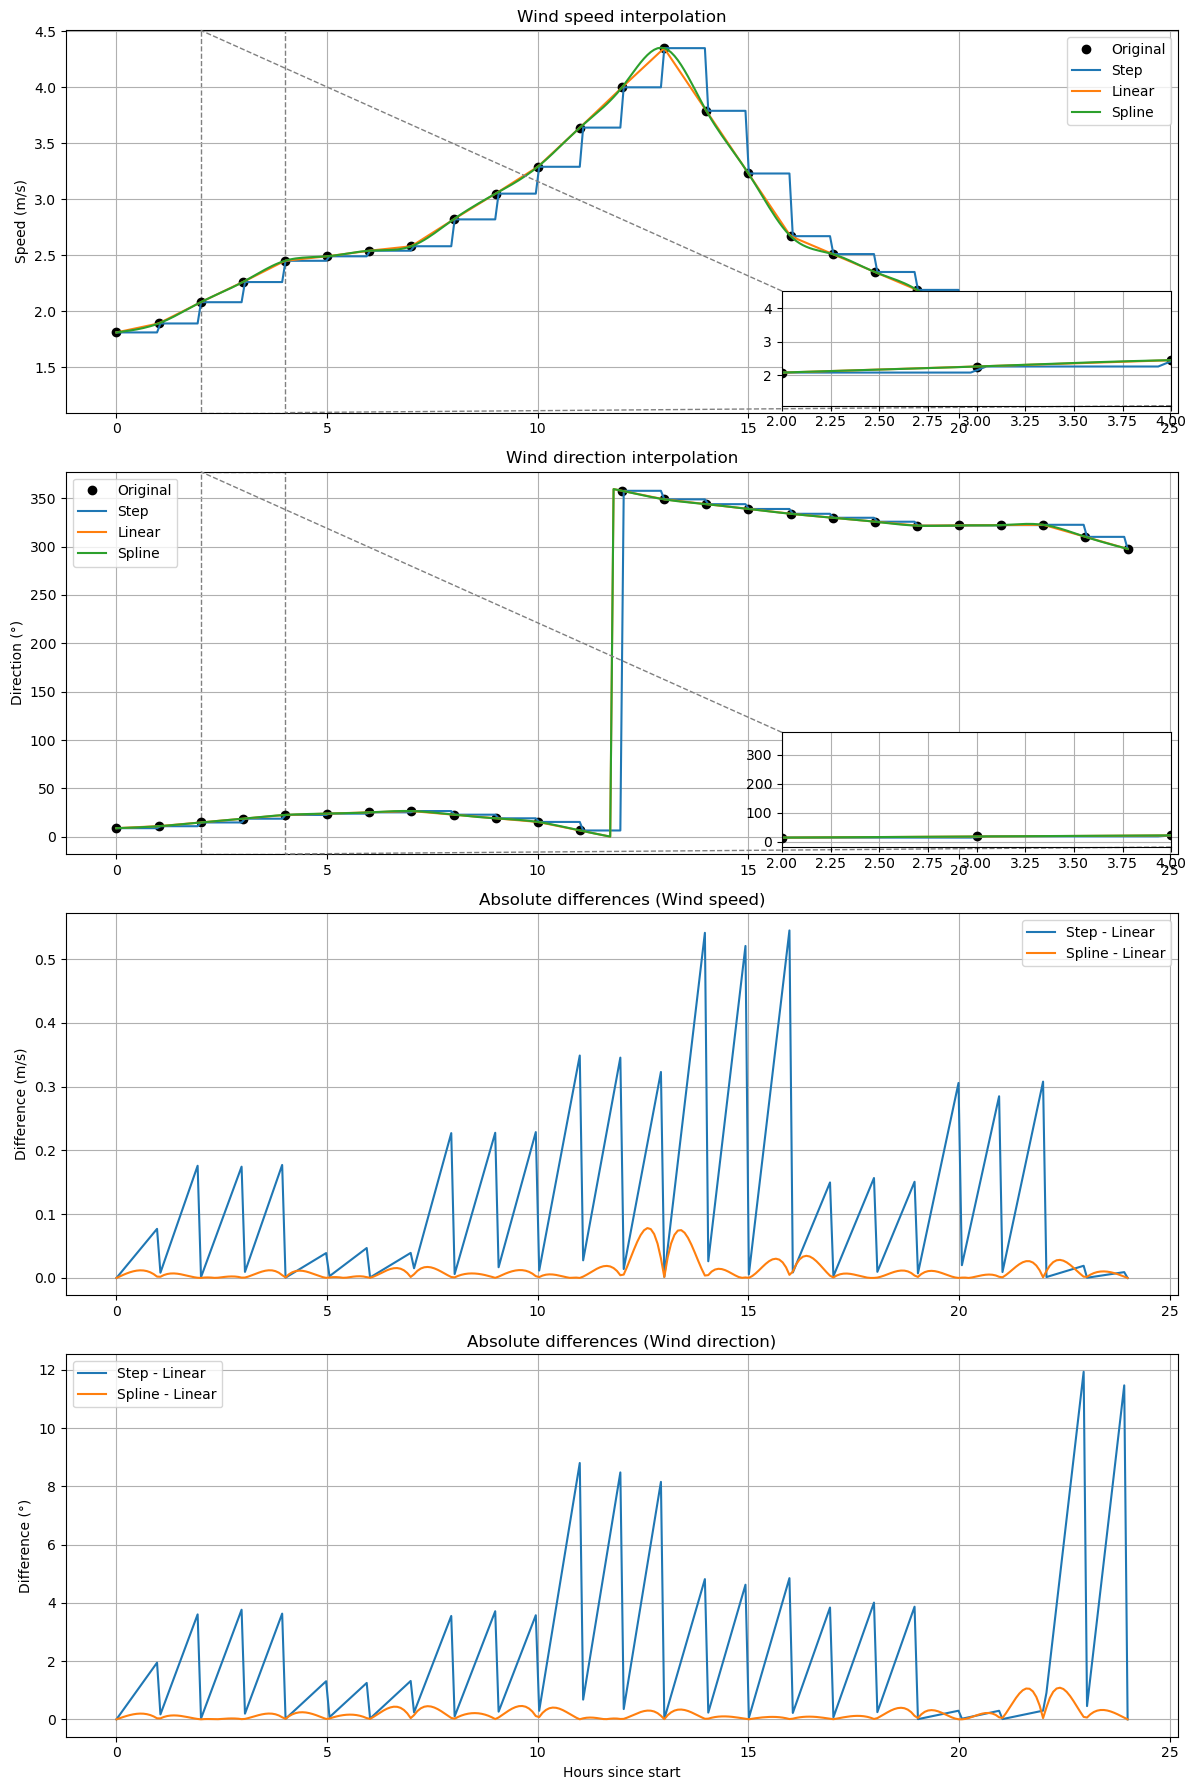

In [4]:
if __name__ == "__main__":
    # Config
    lat, lng = 51.0, 4.0
    cache_filename = "wind_cache.json"
    
    # Historical date: 5 days ago
    days_ago = 5
    start_time_dt = datetime.utcnow() - timedelta(days=days_ago)
    end_time_dt = start_time_dt + timedelta(hours=24)
    
    start_time = start_time_dt.isoformat()
    end_time = end_time_dt.isoformat()
    
    print("Start:", start_time)
    print("End:", end_time)
    
    # Fetch data
    wind_data = fetch_wind_data(lat, lng, start=start_time, end=end_time, cache_file=cache_filename)
    times_hours, wind_speeds, wind_dirs, visibilities = parse_wind_timeseries(wind_data)

    # Interpolate speeds
    fine_times, speed_steps = interpolate_timeseries(times_hours, wind_speeds, method='step')
    _, speed_lin = interpolate_timeseries(times_hours, wind_speeds, method='linear')
    _, speed_spline = interpolate_timeseries(times_hours, wind_speeds, method='spline')

    # Interpolate directions
    _, dir_steps = interpolate_direction(times_hours, wind_dirs, method='step')
    _, dir_lin = interpolate_direction(times_hours, wind_dirs, method='linear')
    _, dir_spline = interpolate_direction(times_hours, wind_dirs, method='spline')

    # Zoom region in hours
    zoom_region = (2, 4)

    # Plot everything
    plot_results(times_hours, wind_speeds, fine_times, speed_steps, speed_lin, speed_spline,
                 wind_dirs, dir_steps, dir_lin, dir_spline, zoom_region=zoom_region)

## Wind data @ 200hPa (12km Altitude)

In [5]:
def fetch_wind_data(lat, lng, params=("windSpeed200hpa","windDirection200hpa","gust","visibility"), start=None, end=None, cache_file="wind_cache_200hpa.json"):
    if os.path.exists(cache_file):
        print(f"Loading data from cache file: {cache_file}")
        with open(cache_file, "r") as f:
            data = json.load(f)
        return data["hours"]
    
    headers = {"Authorization": API_KEY}
    payload = {
        "lat": lat,
        "lng": lng,
        "params": ",".join(params),
    }
    if start:
        payload["start"] = start
    if end:
        payload["end"] = end

    print("Fetching data from Stormglass API...")
    resp = requests.get(BASE_URL, params=payload, headers=headers)
    resp.raise_for_status()
    data = resp.json()
    
    with open(cache_file, "w") as f:
        json.dump(data, f)
    print(f"Data saved to {cache_file}")

    return data["hours"]

def parse_wind_timeseries(wind_data):
    times_str = [sample["time"] for sample in wind_data]
    wind_speeds = [sample["windSpeed200hpa"]["sg"] for sample in wind_data]
    wind_dirs = [sample["windDirection200hpa"]["sg"] for sample in wind_data]
    visibilities = [sample["visibility"]["sg"] for sample in wind_data]

    times_dt = [datetime.fromisoformat(t.replace("Z", "+00:00")) for t in times_str]
    t0 = times_dt[0]
    times_hours = np.array([(t - t0).total_seconds() / 3600 for t in times_dt])

    return times_hours, wind_speeds, wind_dirs, visibilities


def interpolate_timeseries(times_hours, values, fine_resolution=300, method='linear'):
    fine_times = np.linspace(times_hours[0], times_hours[-1], fine_resolution)

    if method == 'step':
        interp_func = interp1d(times_hours, values, kind='previous', fill_value="extrapolate")
    elif method == 'linear':
        interp_func = interp1d(times_hours, values, kind='linear', fill_value="extrapolate")
    elif method == 'spline':
        interp_func = CubicSpline(times_hours, values, bc_type='natural')
    else:
        raise ValueError("Invalid interpolation method")

    return fine_times, interp_func(fine_times)

def interpolate_direction(times_hours, wind_dirs, fine_resolution=300, method='linear'):
    dirs_rad = np.radians(wind_dirs)
    u = np.cos(dirs_rad)
    v = np.sin(dirs_rad)

    _, u_interp = interpolate_timeseries(times_hours, u, fine_resolution, method)
    _, v_interp = interpolate_timeseries(times_hours, v, fine_resolution, method)

    interpolated_dirs_rad = np.arctan2(v_interp, u_interp)
    interpolated_dirs_deg = (np.degrees(interpolated_dirs_rad)) % 360

    fine_times = np.linspace(times_hours[0], times_hours[-1], fine_resolution)
    return fine_times, interpolated_dirs_deg

def plot_results(times_hours, wind_speeds, fine_times, speed_steps, speed_lin, speed_spline,
                 wind_dirs, dir_steps, dir_lin, dir_spline, zoom_region=(0, 3)):
    """Plot main interpolations, zoom insets, and error (difference) plots."""

    fig, axs = plt.subplots(4, 1, figsize=(12, 18))

    # Wind speed plot
    axs[0].plot(times_hours, wind_speeds, 'ko', label="Original")
    axs[0].plot(fine_times, speed_steps, label="Step")
    axs[0].plot(fine_times, speed_lin, label="Linear")
    axs[0].plot(fine_times, speed_spline, label="Spline")
    axs[0].set_title("Wind speed interpolation")
    axs[0].set_ylabel("Speed (m/s)")
    axs[0].legend()
    axs[0].grid(True)

    axins1 = inset_axes(axs[0], width="35%", height="30%", loc='lower right')
    axins1.plot(times_hours, wind_speeds, 'ko')
    axins1.plot(fine_times, speed_steps)
    axins1.plot(fine_times, speed_lin)
    axins1.plot(fine_times, speed_spline)
    axins1.set_xlim(zoom_region[0], zoom_region[1])
    axins1.grid(True)
    mark_inset(axs[0], axins1, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

    # Wind direction plot
    axs[1].plot(times_hours, wind_dirs, 'ko', label="Original")
    axs[1].plot(fine_times, dir_steps, label="Step")
    axs[1].plot(fine_times, dir_lin, label="Linear")
    axs[1].plot(fine_times, dir_spline, label="Spline")
    axs[1].set_title("Wind direction interpolation")
    axs[1].set_ylabel("Direction (°)")
    axs[1].legend()
    axs[1].grid(True)

    axins2 = inset_axes(axs[1], width="35%", height="30%", loc='lower right')
    axins2.plot(times_hours, wind_dirs, 'ko')
    axins2.plot(fine_times, dir_steps)
    axins2.plot(fine_times, dir_lin)
    axins2.plot(fine_times, dir_spline)
    axins2.set_xlim(zoom_region[0], zoom_region[1])
    axins2.grid(True)
    mark_inset(axs[1], axins2, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

    # Error plots for wind speed
    axs[2].plot(fine_times, np.abs(speed_steps - speed_lin), label="Step - Linear")
    axs[2].plot(fine_times, np.abs(speed_spline - speed_lin), label="Spline - Linear")
    axs[2].set_title("Absolute differences (Wind speed)")
    axs[2].set_ylabel("Difference (m/s)")
    axs[2].legend()
    axs[2].grid(True)

    # Error plots for wind direction
    diff_step_dir = np.abs((dir_steps - dir_lin + 180) % 360 - 180)
    diff_spline_dir = np.abs((dir_spline - dir_lin + 180) % 360 - 180)

    axs[3].plot(fine_times, diff_step_dir, label="Step - Linear")
    axs[3].plot(fine_times, diff_spline_dir, label="Spline - Linear")
    axs[3].set_title("Absolute differences (Wind direction)")
    axs[3].set_xlabel("Hours since start")
    axs[3].set_ylabel("Difference (°)")
    axs[3].legend()
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

Start: 2025-07-30T16:47:36.654681
End: 2025-07-31T16:47:36.654681
Loading data from cache file: wind_cache_200hpa.json


/var/folders/4x/pkjmkz2j6f9dp015w5gk_s7m0000gq/T/ipykernel_2622/2618644085.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


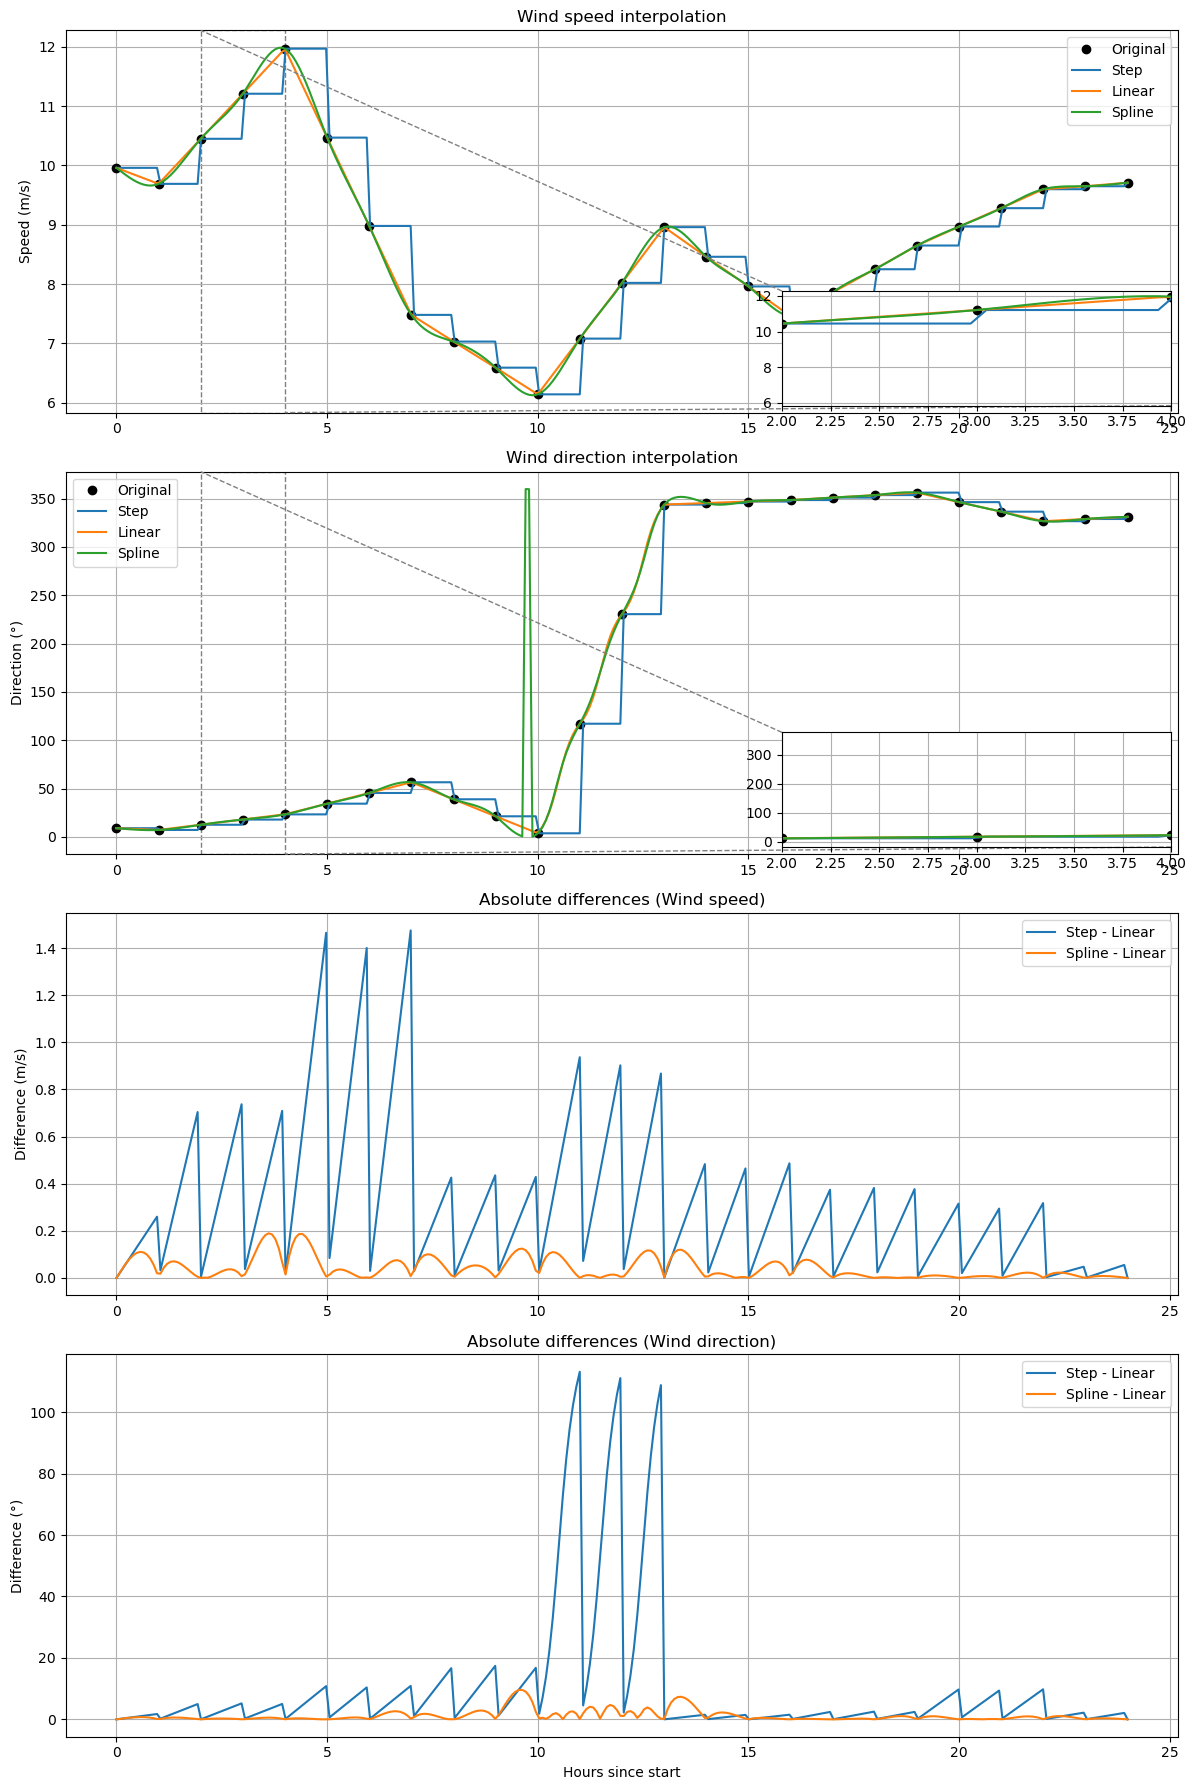

In [6]:
if __name__ == "__main__":
    # Config
    lat, lng = 51.0, 4.0
    cache_filename = "wind_cache_200hpa.json"
    
    # Historical date: 5 days ago
    days_ago = 5
    start_time_dt = datetime.utcnow() - timedelta(days=days_ago)
    end_time_dt = start_time_dt + timedelta(hours=24)
    
    start_time = start_time_dt.isoformat()
    end_time = end_time_dt.isoformat()
    
    print("Start:", start_time)
    print("End:", end_time)
    
    # Fetch data
    wind_data = fetch_wind_data(lat, lng, start=start_time, end=end_time, cache_file=cache_filename)
    times_hours, wind_speeds, wind_dirs, visibilities = parse_wind_timeseries(wind_data)

    # Interpolate speeds
    fine_times, speed_steps = interpolate_timeseries(times_hours, wind_speeds, method='step')
    _, speed_lin = interpolate_timeseries(times_hours, wind_speeds, method='linear')
    _, speed_spline = interpolate_timeseries(times_hours, wind_speeds, method='spline')

    # Interpolate directions
    _, dir_steps = interpolate_direction(times_hours, wind_dirs, method='step')
    _, dir_lin = interpolate_direction(times_hours, wind_dirs, method='linear')
    _, dir_spline = interpolate_direction(times_hours, wind_dirs, method='spline')

    # Zoom region in hours
    zoom_region = (2, 4)

    # Plot everything
    plot_results(times_hours, wind_speeds, fine_times, speed_steps, speed_lin, speed_spline,
                 wind_dirs, dir_steps, dir_lin, dir_spline, zoom_region=zoom_region)

In [7]:
# for sample in wind_data:
#     time = sample["time"]
#     wind_speed = sample["windSpeed"]["sg"]
#     wind_dir = sample["windDirection"]["sg"]
#     gust = sample.get("gust", {}).get("sg", "N/A")
#     visibility = sample.get("visibility", {}).get("sg", "N/A")
#     print(f"{time} UTC — speed {wind_speed} m/s, direction {wind_dir}°, gust {gust} m/s, visibility {visibility} km")
#     #### Direction 0° is towards North --> Increases clockwise